In [37]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
md_zip_ranges = [
    (20331,20331),
    (20335,20797),
    (20812,21930)
]

md_zips = ['%05d' % zipc for zip_range in md_zip_ranges
                     for zipc in range(zip_range[0],zip_range[1]+1)]

cases = pd.DataFrame(
    [np.NaN for _ in range(len(md_zips))],
    index=md_zips,
    columns=['cases']
)

# MD County COVID-19 Cases By Zip Code

In [3]:
zips_json = requests.get('https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/TEST_ZIPCodeCases/FeatureServer/0/query?f=json&where=ProtectedCount%3E%3D8&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=*&orderByFields=ProtectedCount%20desc&outSR=102100&resultOffset=0&resultRecordCount=300&cacheHint=true')

current_cases_d = dict((x['attributes']['ZIPCODE1'],x['attributes']['ProtectedCount'])
                        for x in zips_json.json()['features'])

current_cases = pd.DataFrame(
    current_cases_d.values(),
    index=current_cases_d.keys(),
    columns=['cases'])
current_cases

,cases
21215,137
20904,132
20906,126
20902,125
20744,122
...,...
20714,8
20754,8
21104,8
21131,8


In [7]:
cases.update(current_cases)
cases[cases['cases'].notnull()]

,cases
20601,36.0
20602,44.0
20603,62.0
20607,22.0
20613,37.0
...,...
21801,12.0
21804,14.0
21811,8.0
21911,14.0


Loading 2010 census data by zip code.  Data is broken down by age range and gender.  Summary rows have no gender.

population,minimum_age,maximum_age,gender,zipcode,geo_id

In [8]:
pop = pd.read_csv('population_by_zip_2010.csv',dtype={'zipcode': str})
pop['ZIPCODE'] = pop['zipcode']
pop.set_index('ZIPCODE')

print(type(pop['ZIPCODE'].values[0]))
pop = pop[(pop['gender'] != 'male') & (pop['gender'] != 'female')]

<class 'str'>


Merge case data for Anne Arundel county with population

In [9]:
pop_cases = cases.merge(pop,left_on=cases.index,right_on='ZIPCODE')
pop_cases.loc[pop_cases.ZIPCODE == '21122']

,cases,population,minimum_age,maximum_age,gender,zipcode,geo_id,ZIPCODE
228,57.0,60576,NaN,NaN,NaN,21122,8600000US21122,21122


Read zip codes geo file and merge with population data

In [13]:
zips = gpd.read_file('cb_2018_us_zcta510_500k.shp')
zips['ZIPCODE'] = zips['ZCTA5CE10']
zips.set_index('ZIPCODE')
zips = zips.merge(pop_cases,on='ZIPCODE',how='inner')
zips

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,ZIPCODE,cases,population,minimum_age,maximum_age,gender,zipcode,geo_id
0,21529,8600000US21529,21529,9382561,85948,"POLYGON ((-78.78953 39.72296, -78.77455 39.722...",21529,NaN,631,NaN,NaN,NaN,21529,8600000US21529
1,20899,8600000US20899,20899,204571,0,"POLYGON ((-77.21909 39.14701, -77.21505 39.145...",20899,NaN,142,NaN,NaN,NaN,20899,8600000US20899
2,21717,8600000US21717,21717,944626,10584,"POLYGON ((-77.44416 39.33554, -77.43851 39.341...",21717,NaN,54,NaN,NaN,NaN,21717,8600000US21717
3,21802,8600000US21802,21802,136026,0,"POLYGON ((-75.58453 38.34543, -75.58163 38.346...",21802,NaN,89,NaN,NaN,NaN,21802,8600000US21802
4,20520,8600000US20520,20520,83729,0,"POLYGON ((-77.05012 38.89602, -77.04802 38.896...",20520,NaN,0,NaN,NaN,NaN,20520,8600000US20520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,21671,8600000US21671,21671,5472621,8925145,"POLYGON ((-76.34647 38.69205, -76.34380 38.695...",21671,NaN,756,NaN,NaN,NaN,21671,8600000US21671
480,21104,8600000US21104,21104,43984996,1909783,"POLYGON ((-76.95129 39.31348, -76.95050 39.312...",21104,8.0,4601,NaN,NaN,NaN,21104,8600000US21104
481,20687,8600000US20687,20687,16037034,20293062,"POLYGON ((-76.38286 38.09058, -76.38138 38.091...",20687,NaN,313,NaN,NaN,NaN,20687,8600000US20687
482,21131,8600000US21131,21131,57562383,3576073,"POLYGON ((-76.63103 39.53060, -76.62870 39.531...",21131,8.0,7253,NaN,NaN,NaN,21131,8600000US21131


# Cases per 1,000

In [17]:
zips['density'] = zips['cases'] / (zips['population'] / 1_000)
zips.set_index('ZIPCODE')
print(zips[['ZIPCODE','density','cases','population']].sort_values('density'))

    ZIPCODE   density  cases  population
39    21502  0.202703    9.0       44400
72    21811  0.354767    8.0       22550
164   21804  0.363721   14.0       38491
192   21014  0.388382   14.0       36047
393   21801  0.400521   12.0       29961
..      ...       ...    ...         ...
476   20763       NaN    NaN        2664
478   20662       NaN    NaN        2934
479   21671       NaN    NaN         756
481   20687       NaN    NaN         313
483   20625       NaN    NaN        1062

[484 rows x 4 columns]


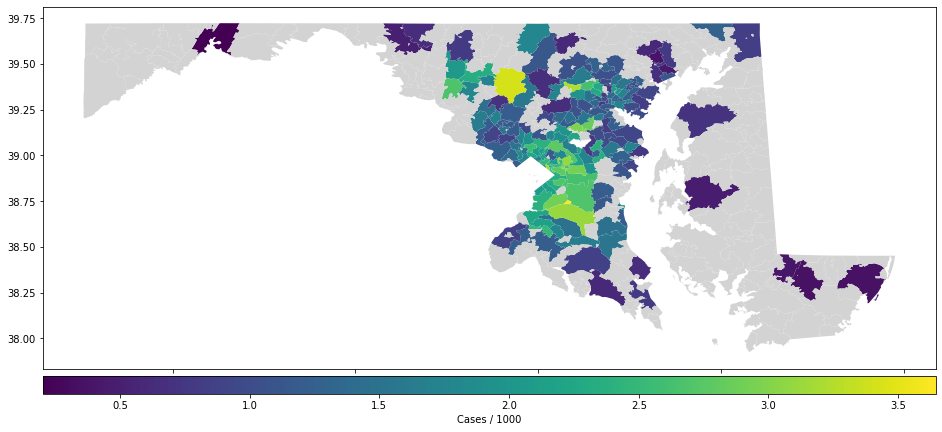

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
zplot = zips.plot(column='density',
                  #figsize=(16,32),
                  legend=True,
                  ax=ax, cax=cax,
                  legend_kwds={
                    'label': "Cases / 1000",
                    'orientation': "horizontal"  
                  },
                  missing_kwds={
                      "color": "lightgrey",
                      "label": "Missing values"
                  })
#_ = zips.apply(lambda x: zplot.annotate(s=x.ZCTA5CE10, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)